In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ticktack
from ticktack import fitting
import os
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
mpl.style.use('seaborn-colorblind')
from ticktack import resample
import pandas as pd
import jax.numpy as jnp
from jax import jit
from scipy.ndimage.filters import gaussian_filter1d as gaussfilt
from astropy.table import Table

In [2]:
@jit
def super_gaussian(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
@jit
def super_gaussian_pulse(t, *args):
    start_time, duration, area = jnp.array(list(args)).reshape(-1)
    height = super_gaussian(t, start_time, duration, area)
    production = 1.76 + height # 1.76 is the steady state production rate for the Brehm21 model
    return production

In [3]:
sf0 = fitting.SingleFitter("Brehm21", "Brehm21")
sf0.load_data("data/7176BCE_Short.csv")
sf0.compile_production_model(super_gaussian_pulse)

INFO[2022-04-08 10:49:34,266]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-04-08 10:49:34,267]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-04-08 10:49:34,268]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-04-08 10:49:34,269]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# chain = sf0.MarkovChainSampler(jnp.array([-7176, 0.3, 6.5]), 
#                               likelihood=sf0.log_joint_likelihood,
#                               args=(jnp.array([-7180., 0., 0.]),
#                                     jnp.array([-7173., 5., 15.]),
#                                    ), 
#                               burnin=500, production=500)

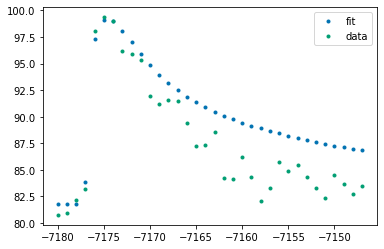

In [5]:
plt.plot(sf0.time_data, sf0.dc14([-7.17654093e+03,  4.83412468e-01,  6.56324454e+00]), ".", label="fit")
plt.plot(sf0.time_data, sf0.d14c_data, ".", label="data")
plt.legend()

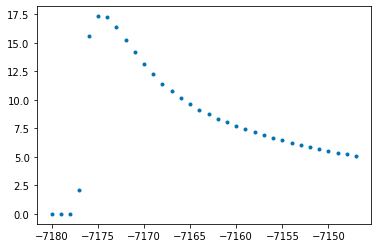

In [6]:
plt.plot(sf0.time_data, sf0.dc14([-7.17654093e+03,  4.83412468e-01,  6.56324454e+00]) - sf0.offset, ".") # without offset

In [7]:
sf = fitting.SingleFitter("Brehm21", "Brehm21")
sf.load_data("data/7176BCE.csv")
sf.d14c_data = np.interp(sf.annual, sf.time_data, sf.d14c_data)
sf.d14c_data_error = np.interp(sf.annual, sf.time_data, sf.d14c_data_error)
sf.time_data = sf.annual
sf.d14c_data.size

50

In [8]:
sf.d14c_data[np.in1d(sf.time_data, sf0.time_data)] = sf.d14c_data[np.in1d(sf.time_data, sf0.time_data)] - sf0.dc14([-7.17654093e+03,  4.83412468e-01,  6.56324454e+00]) + sf0.offset

Text(0.5, 1.0, 'After removing 7176 event')

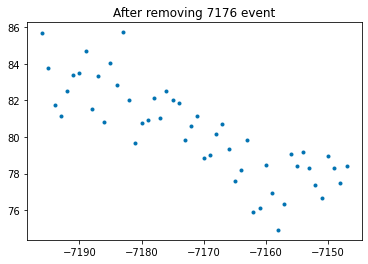

In [9]:
plt.plot(sf.time_data, sf.d14c_data, ".")
plt.title("After removing 7176 event")

Text(0.5, 1.0, 'Before removing 7176 event')

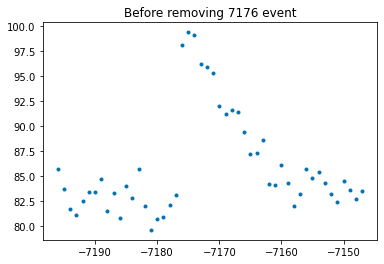

In [10]:
sf1 = fitting.SingleFitter("Brehm21", "Brehm21")
sf1.load_data("data/7176BCE.csv")
sf1.d14c_data = np.interp(sf1.annual, sf1.time_data, sf1.d14c_data)
sf1.d14c_data_error = np.interp(sf1.annual, sf1.time_data, sf1.d14c_data_error)
sf1.time_data = sf1.annual
sf1.d14c_data.size
plt.plot(sf1.time_data, sf1.d14c_data, ".")
plt.title("Before removing 7176 event")

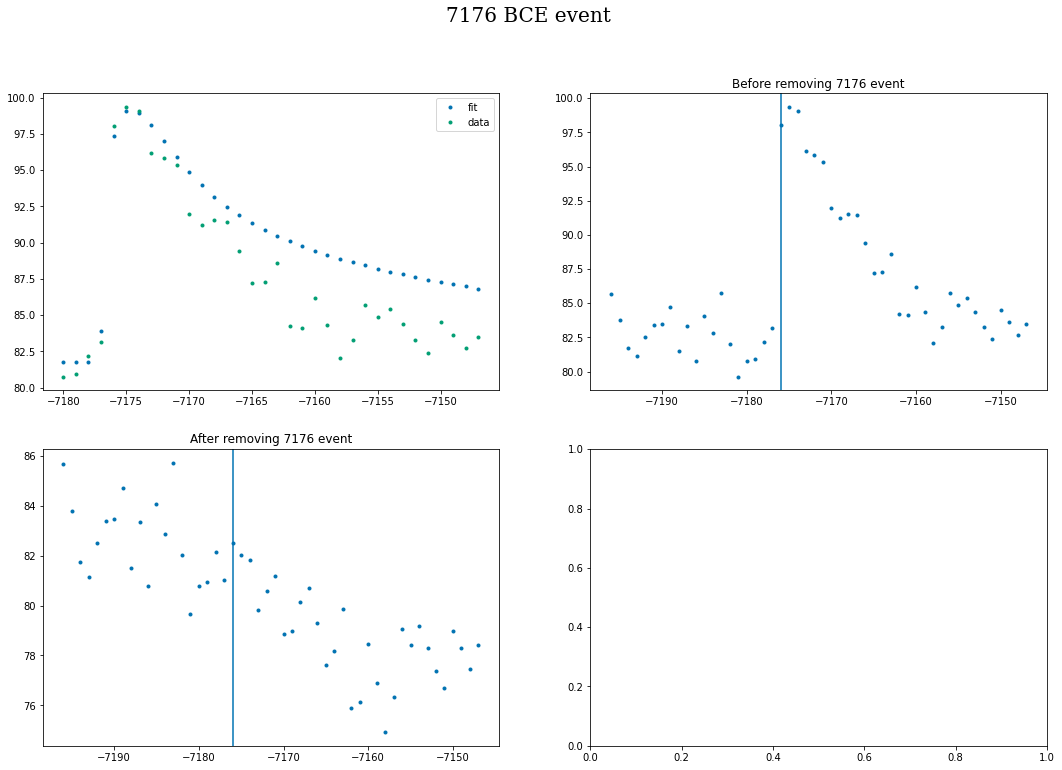

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs[0, 0].plot(sf0.time_data, sf0.dc14([-7.17654093e+03,  4.83412468e-01,  6.56324454e+00]), ".", label="fit")
axs[0, 0].plot(sf0.time_data, sf0.d14c_data, ".", label="data")
axs[0, 0].legend()
axs[0, 1].plot(sf1.time_data, sf1.d14c_data, ".")
axs[0, 1].axvline(-7176)
axs[0, 1].set_title("Before removing 7176 event")
axs[1, 0].plot(sf.time_data, sf.d14c_data, ".")
axs[1, 0].set_title("After removing 7176 event");
axs[1, 0].axvline(-7176)
fig.suptitle("7176 BCE event", fontsize=20, fontfamily="serif")
fig.savefig("7176BCE_diag.jpg")

In [12]:
result = sf.MC_reconstruct(iters=1000)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.18it/s]


In [13]:
from ticktack import resample

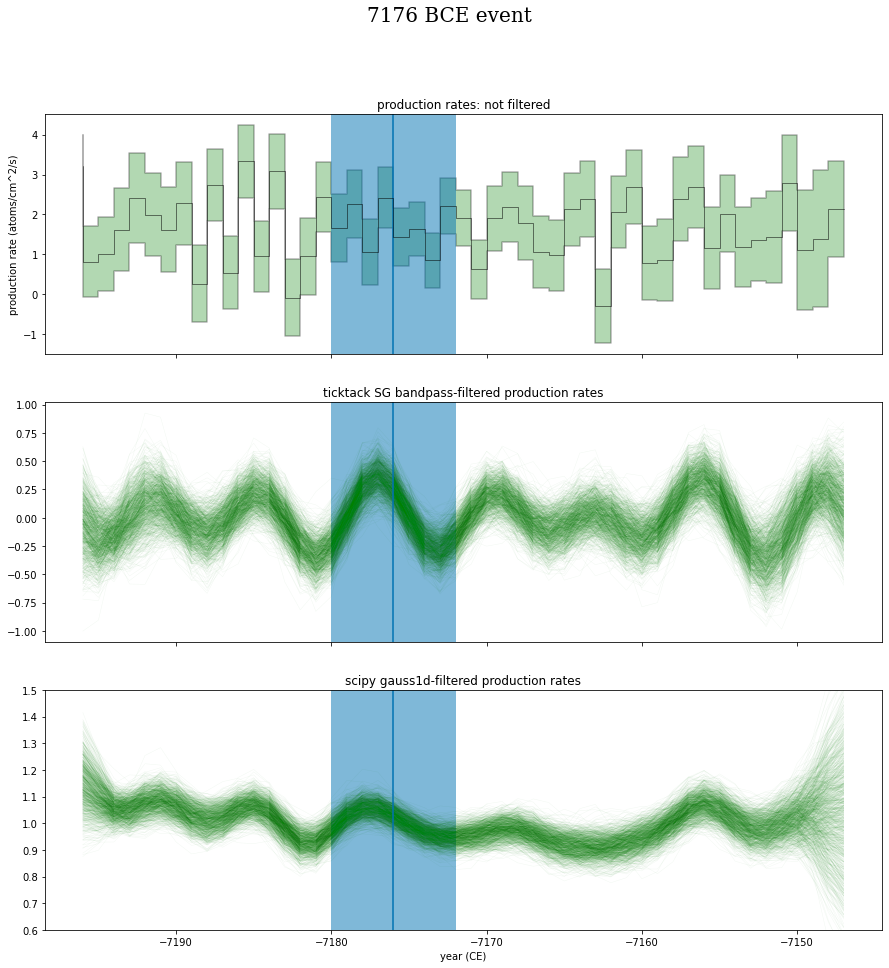

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
r = resample.Resampler()
mean = np.mean(result, axis=0)
std = np.std(result, axis=0)
axs[0].errorbar(sf.time_data, mean, color='black', drawstyle="steps", lw=0.5)
axs[0].fill_between(sf.time_data, mean-std, mean+std, 
                    step='pre', alpha=0.3, facecolor="g", edgecolor=(0, 0, 0, 0.8), lw=1.5)
axs[0].set_ylabel("production rate (atoms/cm^2/s)")
axs[0].axvspan(-7180, -7172, alpha=0.5)
axs[0].axvline(-7176)
axs[0].set_title("production rates: not filtered")

new_sigs = r.bandpass_super_gaussian(result, l=1./9.677, sz=0.05)
for new_sig in new_sigs:
    axs[1].plot(sf.time_data, new_sig, color='g', lw=0.5, alpha=0.05)
axs[1].axvspan(-7180, -7172, alpha=0.5)
axs[1].axvline(-7176)
axs[1].set_title("ticktack SG bandpass-filtered production rates")

smootheds = gaussfilt(result, 2)
smootheds /= np.median(smootheds)
for smoothed in smootheds:
    axs[2].plot(sf.time_data, smoothed, color='g', lw=0.5, alpha=0.05)
axs[2].axvspan(-7180, -7172, alpha=0.5)
axs[2].axvline(-7176)
axs[2].set_ylim(0.6, 1.5)
axs[2].set_title("scipy gauss1d-filtered production rates")
axs[2].set_xlabel("year (CE)")
fig.suptitle("7176 BCE event", fontsize=20, fontfamily="serif")
fig.savefig("7176BCE.jpg")